<a class="anchor" id="top"></a>

# Topic Modeling with LDA to Generate Target Risk Topics
Author: Ainesh Pandey

In this notebook, we will perform topic modeling using [LDA (Latent Dirichlet Allocation)](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2) on the _Lesson(s) Learned_ column of the `lessons_learned.csv` dataframe. The purpose of this analysis is to attempt to organize the different projects into risk topics. Assuming the LDA model produces reasonable topics, we can use the topic classification as ground truth in a modeling objective.

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Prototyping Baseline Solution](#step-2) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [27]:
import warnings
warnings.filterwarnings('ignore')

# basic data science packages
import pandas as pd
import numpy as np
np.random.seed(5)

# gensim packages for text preprocessing and LDA
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# nltk packages for text preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

# 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import OneSidedSelection

# modeling packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import statistics

# visualization packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

### Data
We import `lessons_learned.csv` and keep all of the data. After some exploratory data analysis, we'll choose which features we will keep as inputs.

In [2]:
df_lessons = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv', encoding='cp1252')

display(df_lessons.shape)
df_lessons.head()

(2101, 17)

,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat..."
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,..."
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate..."
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S..."
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M..."


Next, we will import `risk_classifications.csv`, which we created in [GenerateRiskTarget.ipynb](GenerateRiskTarget.ipynb).

In [3]:
df_riskclasses = pd.read_csv('../data/risk_classifications.csv')

display(df_riskclasses.shape)
df_riskclasses.head()

(2086, 2)

,Lesson ID,Risk Class
0,30004,4
1,30101,4
2,29801,4
3,29702,4
4,29103,4


We will combine both dataframes into a master dataframe. We also drop any rows where Risk Class == 3, based on our findings in the previous notebook.

In [4]:
df_master = df_lessons.merge(df_riskclasses, on='Lesson ID', how='inner')
df_master = df_master[df_master['Risk Class'] != 3].reset_index()

display(df_master.shape)
df_master.head()

(2067, 19)

,index,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics,Risk Class
0,0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat...",4
1,1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,...",4
2,2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate...",4
3,3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S...",4
4,4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M...",4


<a class="anchor" id="step-2"></a>

## Prototyping Baseline Solution

The problem at hand is a classification task; we want to use data available about projects before they are officially launched to predict what class of risk they fall under. Therefore, we intend to generate a text-based description of each project, carry out basic NLP transformations to convert the descriptions into tabular data, and utilize several different multi-class classification algorithms to try to accurately predict which class of risk each project is likely to fall under.

We will create a prototype of the classification model using just the _Title_ and _Abstract_. Depending on the performance of the model, we may augment the inputs with other features as needed.

### Prep Dataframe for Prototyping

First, we need to drop all irrelevant columns.

In [5]:
df_prototyping = df_master[['Lesson ID', 'Title', 'Abstract', 'Risk Class']]

display(df_prototyping.shape)
df_prototyping.head()

(2067, 4)

,Lesson ID,Title,Abstract,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,4
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,4
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,4
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,4
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,4


Next, we need to combine the _Title_ and _Abstract_ into one block of text.

In [6]:
df_prototyping['Description'] = df_prototyping['Title'].astype(str) + ' ' + df_prototyping['Abstract'].astype(str)
if 'Title' in df_prototyping.columns:
    df_prototyping.drop(['Title', 'Abstract'], axis=1, inplace=True)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 3)

,Lesson ID,Risk Class,Description
0,30004,4,Relationship of Government and Contractor Risk...
1,30101,4,Cable Harness Wiring and Connector Anomalies C...
2,29801,4,Best Practices for the Elemental Profiling of ...
3,29702,4,Integration and Dependency Between Different A...
4,29103,4,Copper Tube Pinch Failure While pinching coppe...


INSERT TEXT HERE

In [7]:
stemmer = PorterStemmer()
def preprocess(text):
    global stemmer
    result = ''
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result = result + ' ' + stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
    return result.strip()

vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess,
                             stop_words = 'english', strip_accents='unicode', lowercase=True)
pca = PCA(n_components=100)

tfidf_matrix = vectorizer.fit_transform(df_prototyping['Description'])
tfidf_df     = pd.DataFrame(tfidf_matrix.todense())
pca_matrix   = pca.fit_transform(tfidf_df)

display(pca_matrix.shape)

(2067, 100)

In [8]:
df_prototyping = df_prototyping[['Lesson ID', 'Risk Class']]
df_prototyping = pd.concat([df_prototyping, pd.DataFrame(pca_matrix)], axis=1)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,4,-0.033854,0.082005,0.259533,0.067744,0.047458,-0.047642,-0.051692,0.031634,...,0.019679,-0.015403,0.036234,-0.084950,-0.029656,0.033625,0.001141,-0.062345,0.025706,-0.034294
1,30101,4,0.100768,-0.114094,0.037132,-0.092427,0.037966,-0.012349,0.005554,-0.059482,...,-0.045800,0.118993,0.021418,0.100452,-0.092462,-0.006570,0.046110,-0.038476,0.038111,0.053453
2,29801,4,-0.063784,0.006688,-0.007435,-0.019258,-0.015219,-0.060059,0.013481,-0.061282,...,0.043561,-0.020959,-0.001669,0.007417,0.032759,0.021461,-0.037661,-0.032862,0.047159,0.027639
3,29702,4,-0.034003,0.000247,-0.011641,-0.089555,0.108049,0.064706,-0.057105,-0.028622,...,-0.001350,-0.021536,0.085029,0.035786,-0.122584,0.009606,0.091326,-0.005283,-0.045413,-0.009746
4,29103,4,-0.051290,-0.010528,-0.037038,-0.011080,-0.020117,-0.037159,0.022863,-0.037152,...,0.018976,0.082383,-0.059004,-0.073744,-0.074187,0.030126,-0.114796,0.099240,0.010487,0.045370


In [9]:
X = df_prototyping.drop(['Lesson ID', 'Risk Class'], axis=1)
y = df_prototyping['Risk Class']

X, y = OneSidedSelection(random_state=5).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

print('Training Output Variable Distribution')
display(y_train.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test.value_counts())


Training Output Variable Distribution


4    989
0    258
2     66
1      7
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


4    425
0    111
2     28
1      3
Name: Risk Class, dtype: int64

In [28]:
scorer = make_scorer(f1_score, average = 'weighted')

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}


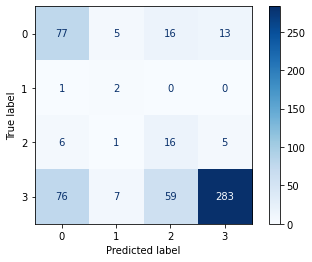

In [31]:
# create parameter grid to fine-tune model
param_grid = {
    'solver': ['newton-cg', 'lbfgs'],
    'penalty': ['none', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
}

# run the cross-validated grid search to identify the best parameters for the model
CV_lm = GridSearchCV(estimator=LogisticRegression(class_weight='balanced', random_state=5),
                     scoring=scorer, param_grid=param_grid, n_jobs=-1, verbose=0).fit(X_train, y_train)

# extract the best parameters, as selected by the grid search
best_params = CV_lm.best_params_
best_solver = best_params['solver']
best_penalty = best_params['penalty']
best_C = best_params['C']
print(best_params)

# create the final LogisticRegression
best_lm = LogisticRegression(class_weight='balanced', random_state=5,
                             solver=best_solver,
                             penalty=best_penalty,
                             C=best_C).fit(X_train, y_train)
lm_pred = best_lm.predict(X_test)
 
# creating a confusion matrix
lm_cm = confusion_matrix(y_test, lm_pred)
dist = ConfusionMatrixDisplay(confusion_matrix=lm_cm).plot(cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 200}


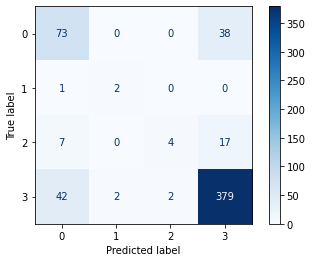

In [40]:
# create parameter grid to fine-tune model
param_grid = { 
    'n_estimators': range(100, 400, 100),
    'max_features': ['auto', 'log2', 0.25, 0.33, 0.5],
    'max_depth' : [None, 5, 8],
    'criterion' : ['gini', 'entropy']
}

# run the cross-validated grid search to identify the best parameters for the model
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                      param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

# extract the best parameters, as selected by the grid search
best_params = CV_rfc.best_params_
best_n_estimators = best_params['n_estimators']
best_max_features = best_params['max_features']
best_max_depth = best_params['max_depth']
best_criterion = best_params['criterion']
print(best_params)

# create the final RandomForestClassifier
best_rfc = RandomForestClassifier(class_weight='balanced', random_state=5,
                                  max_features=best_max_features,
                                  n_estimators=best_n_estimators,
                                  max_depth=best_max_depth,
                                  criterion=best_criterion).fit(X_train, y_train)
rfc_pred = best_rfc.predict(X_test)

# creating a confusion matrix
rfc_cm = confusion_matrix(y_test, rfc_pred)
dist = ConfusionMatrixDisplay(confusion_matrix=rfc_cm).plot(cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5}


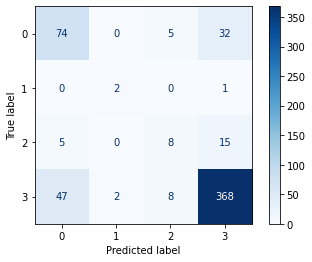

In [35]:
# create parameter grid to fine-tune model
param_grid = {
    'max_depth': [15, 20, -1],
    'num_leaves': [10, 20, 30],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [0, 0.5, 1.0],
    'min_split_gain': [0, 0.2, 0.4]
}

# run the cross-validated grid search to identify the best parameters for the model
CV_lgb = GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                      param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

# extract the best parameters, as selected by the grid search
best_params = CV_lgb.best_params_
best_max_depth = best_params['max_depth']
best_num_leaves = best_params['num_leaves']
best_reg_alpha = best_params['reg_alpha']
best_reg_lambda = best_params['reg_lambda']
best_min_split_gain = best_params['min_split_gain']
print(best_params)

# create the final LGBMClassifier
best_lgb = LGBMClassifier(class_weight='balanced', random_state=5,
                          max_depth=best_max_depth,
                          num_leaves=best_num_leaves,
                          reg_alpha=best_reg_alpha,
                          reg_lambda=best_reg_lambda,
                          min_split_gain=best_min_split_gain).fit(X_train, y_train)
lgb_pred = best_lgb.predict(X_test)

# creating a confusion matrix
lgb_cm = confusion_matrix(y_test, lgb_pred)
dist = ConfusionMatrixDisplay(confusion_matrix=lgb_cm).plot(cmap=plt.cm.Blues)
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'algorithm': 'auto', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}


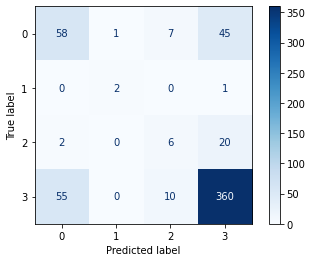

In [36]:
# create parameter grid to fine-tune model
param_grid = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2, 3]
}

# run the cross-validated grid search to identify the best parameters for the model
CV_knn = GridSearchCV(estimator=KNeighborsClassifier(), scoring=scorer,
                      param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

# extract the best parameters, as selected by the grid search
best_params = CV_knn.best_params_
best_n_neighbors = best_params['n_neighbors']
best_weights = best_params['weights']
best_algorithm = best_params['algorithm']
best_p = best_params['p']
print(best_params)

# create the final KNeighborsClassifier
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors,
                          weights=best_weights,
                          algorithm=best_algorithm,
                          p=best_p).fit(X_train, y_train)
knn_pred = best_knn.predict(X_test)

knn_cm = confusion_matrix(y_test, knn_pred)
dist = ConfusionMatrixDisplay(confusion_matrix=knn_cm).plot(cmap=plt.cm.Blues)
plt.show()

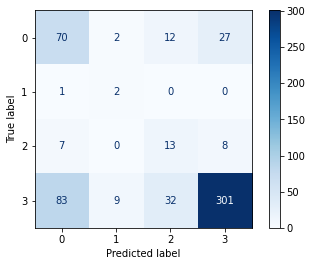

In [37]:
# create the GaussianNB classifier (no tuning, we don't have any priors)
gnb = GaussianNB().fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)

cm = confusion_matrix(y_test, gnb_pred)
dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()

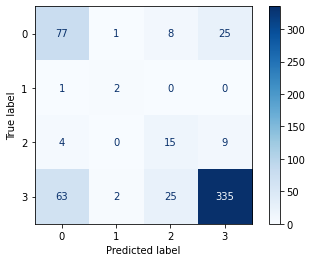

In [38]:
# create a custom ensemble of all of the above methods
df_pred = pd.DataFrame([lm_pred, lgb_pred, knn_pred, gnb_pred]).T
pred = df_pred.apply(statistics.mode, axis=1)

cm = confusion_matrix(y_test, pred)
dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()

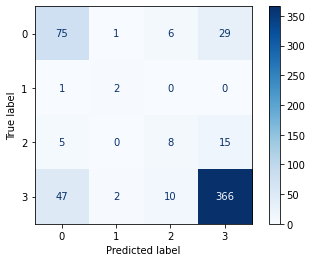

In [41]:
# create a custom ensemble of all of the above methods
df_pred = pd.DataFrame([lm_pred, rfc_pred, lgb_pred, knn_pred, gnb_pred]).T
pred = df_pred.apply(statistics.mode, axis=1)

cm = confusion_matrix(y_test, pred)
dist = ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
# from sklearn.ensemble import VotingClassifier

# #create a dictionary of our models
# estimators=[('lm', lm_pred), ('rfc', rfc_pred), ('lgb', lgb_pred), ('knn', knn_pred), ('gnb', gnb_pred)]

# #create our voting classifier, inputting our models
# ensemble = VotingClassifier(estimators, voting='hard')

# #fit model to training data
# ensemble.fit(X_train, y_train)

# #test our model on the test data
# ensemble.predict(X_test, y_test)

To generate the text-based description, we need to decide which of the available features can add value beyond the _Title_ and _Abstract_ features of the dataframe.

### Remove Irrelevant Features

First, we remove any columns containing data unavailable at the beginning of the project.
- _Lesson(s) Learned_ was used to generate the risk classifications. Logically, we cannot use it as an input. Regardless, it is information that comes to light during the course of the project. Therefore, this column will be dropped.
- The other columns that either relate to _Lesson(s) Learned_ or are post-facto include:
    - _Recommendation(s)_
    - _Date Lesson Occurred_
    - _Driving Event_
    - _Evidence_
    - _The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules_
    - _From what phase of the program or project was this lesson learned captured?_
    - _Where (other lessons, presentations, publications, etc.)?_
- _Publish Date_ is also a post-facto column. Furthermore, we don't expect the publication date to actually impact the risk classification.

In [ ]:
if 'Lesson(s) Learned' in df_master.columns:
    df_master.drop(['Lesson(s) Learned', 'Recommendation(s)', 'Date Lesson Occurred', 'Driving Event', 'Evidence',
                    'The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules',
                    'From what phase of the program or project was this lesson learned captured?',
                    'Where (other lessons, presentations, publications, etc.)?', 'Publish Date'], inplace=True, axis=1)

display(df_master.shape)
df_master.head()

### Categorical Feature Analysis

Next, aside from _Title_ and _Abstract_, we will try to identify which other categorical features (if any) may offer value to the text-based description of the project. We start by checking how many unique values exist for each categorical feature.

In [ ]:
df_master.iloc[:,3:].nunique()

- _Project / Program_ doesn't seem to have a standard format for its values. For prototyping, we will remove this column from analysis and try to see what our initial results look like, before considering including the text from this column in our inputs.
- _NASA Mission Directorate(s)_ seems to be comma-separated values. There may be value in adding them into our analysis.